## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
import sklearn
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                      activation="relu", 
                      name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                      activation="relu", 
                      name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 1024
MOMENTUM = 0.95
BESTONLY = [True, False]
WEIGHTONLY = [False, True]

In [7]:
results = {}
loadedmodel = {}
for bo, wo in itertools.product(BESTONLY, WEIGHTONLY):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print('BESTONLY:', bo, 'WEIGHTONLY:', wo)
    model = build_mlp(input_shape=x_train.shape[1:])
    #model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model_ckpt = keras.callbacks.ModelCheckpoint(
        filepath="./Day086_saved_models/B-%s-W-%s.h5" % (str(bo),str(wo)), 
        monitor="val_loss", 
        save_best_only=bo, 
        save_weights_only=wo)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True, 
              callbacks=[model_ckpt])

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    # Load back
    exp_name_tag = "B-%s-W-%s" % (str(bo),str(wo))
    
    if wo == True:
        loadedmodel[exp_name_tag] = build_mlp(input_shape=x_train.shape[1:])
        loadedmodel[exp_name_tag].compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        loadedmodel[exp_name_tag].load_weights("./Day086_saved_models/%s.h5" % exp_name_tag)
    else:
        loadedmodel[exp_name_tag] = keras.models.load_model("./Day086_saved_models/%s.h5" % exp_name_tag)
        
    loss_loadback, acc_loadback = loadedmodel[exp_name_tag].evaluate(x_test, y_test)

    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'loss-loadback': loss_loadback,
                             'acc-loadback': acc_loadback}

BESTONLY: True WEIGHTONLY: False
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 17s 333us/step - loss: 2.1927 - accuracy: 0.2771 - val_loss: 2.1249 - val_accuracy: 0.2037
Epoch 2/20
50000/50000 [==============================] - 23s 470us/step - loss: 1.7389 - accuracy: 0.3933 - val_loss: 1.9500 - val_accuracy: 0.3061
Epoch 3/20
50000/50000 [==============================] - 20s 403us/step - loss: 1.6105 - accuracy: 0.4345 - val_loss: 1.8356 - val_accuracy: 0.3545
Epoch 4/20
50000/50000 [==============================] - 15s 310us/step - loss: 1.5372 - accuracy: 0.4612 - val_loss: 1.7465 - val_accuracy: 0.3884
Epoch 5/20
50000/50000 [==============================] - 15s 309us/step - loss: 1.4811 - accuracy: 0.4802 - val_loss: 1.6639 - val_accuracy: 0.4119
Epoch 6/20
50000/50000 [==============================] - 16s 311us/step - loss: 1.4345 - accuracy: 0.4965 - val_loss: 1.5954 - val_accuracy: 0.4381
Epoch 7/20
50000/50000 

50000/50000 [==============================] - 17s 347us/step - loss: 1.2345 - accuracy: 0.5719 - val_loss: 1.4740 - val_accuracy: 0.4818
Epoch 14/20
50000/50000 [==============================] - 17s 339us/step - loss: 1.2085 - accuracy: 0.5819 - val_loss: 1.4757 - val_accuracy: 0.4837
Epoch 15/20
50000/50000 [==============================] - 15s 308us/step - loss: 1.1849 - accuracy: 0.5910 - val_loss: 1.4746 - val_accuracy: 0.4839
Epoch 16/20
50000/50000 [==============================] - 15s 310us/step - loss: 1.1609 - accuracy: 0.6003 - val_loss: 1.4774 - val_accuracy: 0.4837
Epoch 17/20
50000/50000 [==============================] - 16s 310us/step - loss: 1.1389 - accuracy: 0.6098 - val_loss: 1.4704 - val_accuracy: 0.4791
Epoch 18/20
50000/50000 [==============================] - 16s 318us/step - loss: 1.1152 - accuracy: 0.6174 - val_loss: 1.4627 - val_accuracy: 0.4872
Epoch 19/20
50000/50000 [==============================] - 16s 311us/step - loss: 1.0923 - accuracy: 0.6260 - va

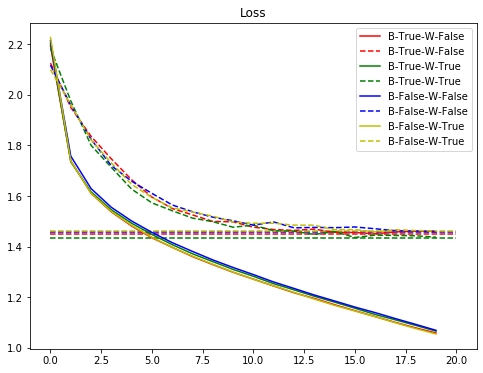

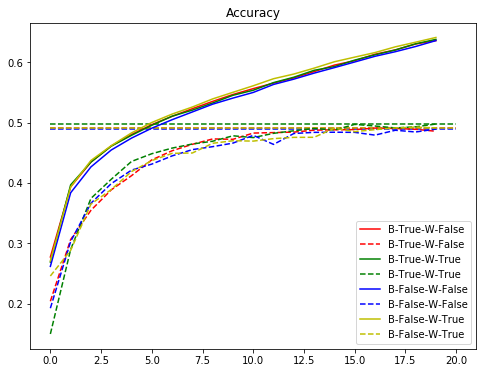

In [8]:
color_bar = ["r", "g", "b", "y", "m", "k"]
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['loss-loadback'], xmin=0, xmax=len(train_loss), linestyles='--', color=color_bar[i])
plt.title("Loss")
#plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['acc-loadback'], xmin=0, xmax=len(train_loss), linestyles='--', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
y_pred = model.predict(x_test)
print(y_pred)

model2 = build_mlp(input_shape=x_train.shape[1:])
model2.load_weights('./Day086_saved_models/B-False-W-True.h5')
y_pred2 = model2.predict(x_test)
print(y_pred2)

if y_pred.all() == y_pred2.all():
    print('y_pred == y_pred2')

[[6.22940576e-03 2.49010585e-02 3.72874811e-02 ... 3.02586879e-04
  4.14970927e-02 2.48297211e-03]
 [1.52492328e-02 3.82584855e-02 2.04233383e-03 ... 6.39299350e-03
  7.45662674e-02 8.61949146e-01]
 [1.22054249e-01 3.78014624e-01 7.20714452e-03 ... 1.41385943e-03
  3.74544054e-01 1.04945101e-01]
 ...
 [8.73165950e-03 8.26719333e-04 2.86712408e-01 ... 5.25673991e-03
  4.00099764e-03 1.55272870e-03]
 [5.68784354e-03 2.05495134e-02 5.70714653e-01 ... 8.80935322e-03
  4.41723969e-03 1.23136565e-02]
 [8.33135750e-03 8.19822401e-03 4.87476178e-02 ... 5.74878514e-01
  2.11931691e-02 1.19857248e-02]]
[[6.22940576e-03 2.49010585e-02 3.72874811e-02 ... 3.02586879e-04
  4.14970927e-02 2.48297211e-03]
 [1.52492328e-02 3.82584855e-02 2.04233383e-03 ... 6.39299350e-03
  7.45662674e-02 8.61949146e-01]
 [1.22054249e-01 3.78014624e-01 7.20714452e-03 ... 1.41385943e-03
  3.74544054e-01 1.04945101e-01]
 ...
 [8.73165950e-03 8.26719333e-04 2.86712408e-01 ... 5.25673991e-03
  4.00099764e-03 1.55272870e-03]